# Lab 3 — recommender systems

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
#%matplotlib inline
#plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [34]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
user = data.map(itemgetter('userId'))
user = user.map(lambda x: (x,1))
user = user.reduceByKey(lambda a,b: a+b)
item = data.map(itemgetter('userId'))
item = item.map(lambda x: (x,1))
item = item.reduceByKey(lambda a,b:a+b)

138493


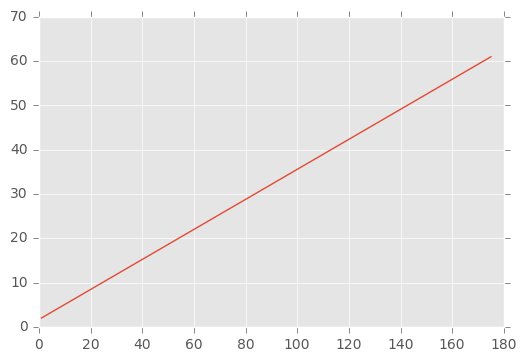

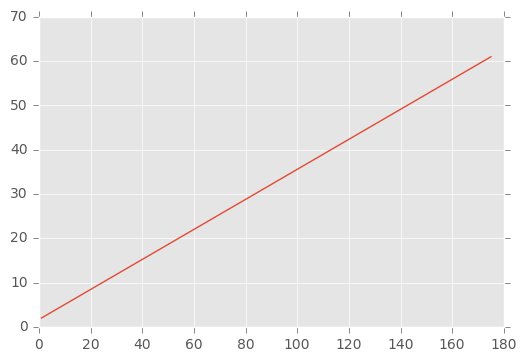

(1, 175)


In [36]:
print(user.count())
x = sorted(user.collect())
y = sorted(item.collect())
plt.plot(x[0],x[1])
plt.show()
plt.plot(y[0],y[1])
plt.show()

print(x[0])
